In [ ]:
import pandas as pd
import numpy as np

np.float_ = np.float64

from prophet import Prophet
import requests
from datetime import datetime, timedelta
import duckdb as db

m = Prophet()
conn = db.connect("file.db")
conn.sql("""
    -- y is the amount charged for the transaction
    -- ds is the time the transaction took place

    CREATE SEQUENCE seq_id START 1;
    CREATE TABLE crypto_transfer (y INTEGER, ds DATETIME UNIQUE)
""")

In [7]:
# Get data

end_time = datetime.now()
print(end_time.timestamp())
start_time = (end_time - timedelta(seconds=3600.0)).timestamp()
print(start_time)

transaction_types = ["CONTRACTCALL", "CRYPTOTRANSFER"]

from typing import Union
from pprint import pprint

def get_data(start_time: float | int, limit: int, transaction_type: str, order: Union["asc", "desc"]):
    url = f"https://testnet.mirrornode.hedera.com/api/v1/transactions?limit={limit}&order={order}&timestamp=gte%3A{start_time}&transactiontype={transaction_type}"
    data = requests.get(url).json()
    transactions = data["transactions"]
    new_transactions: list[dict | None] = []
    for transaction in transactions:
        new_data = {}
        if not transaction["scheduled"] and transaction["result"] == "SUCCESS":
            _, seconds, nanoseconds = transaction["transaction_id"].split("-")
            new_data["charged_tx_fee"] = transaction["charged_tx_fee"]
            new_data["time_tx_occured"] = datetime.fromtimestamp(float(f"{seconds}.{nanoseconds}")).isoformat()

            new_transactions.append(new_data)
    return new_transactions


transactions: list[dict | None] = get_data(start_time, 100, transaction_types[1], "asc")
pprint(transactions)

1723999909.433924
1723996309.433924
[{'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:18.352000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:18.494000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:18.252000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:18.491000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:18.373000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:52:20.092000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:20.182000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:52:20.957000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:52:21.067000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:52:20.945000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:52:21.047000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:52:21.045000'},
 {'charged_tx_fee': 185514, 

In [8]:
try:
    for transaction in transactions:
        conn.sql(f"""
            INSERT INTO crypto_transfer VALUES ('{transaction["charged_tx_fee"]}', '{transaction["time_tx_occured"]}')
        """)
except db.ConstraintException:
    pass

In [9]:
conn.sql("""
    SELECT * FROM crypto_transfer
""").show()

┌────────┬─────────────────────────┐
│   y    │           ds            │
│ int32  │        timestamp        │
├────────┼─────────────────────────┤
│ 185514 │ 2024-08-18 15:52:18.352 │
│ 185514 │ 2024-08-18 15:52:18.494 │
│ 185514 │ 2024-08-18 15:52:18.252 │
│ 185514 │ 2024-08-18 15:52:18.491 │
│ 185514 │ 2024-08-18 15:52:18.373 │
│ 184213 │ 2024-08-18 15:52:20.092 │
│ 185514 │ 2024-08-18 15:52:20.182 │
│ 184213 │ 2024-08-18 15:52:20.957 │
│ 184213 │ 2024-08-18 15:52:21.067 │
│ 184213 │ 2024-08-18 15:52:20.945 │
│    ·   │            ·            │
│    ·   │            ·            │
│    ·   │            ·            │
│ 185358 │ 2024-08-18 16:00:28.503 │
│ 185358 │ 2024-08-18 16:00:28.749 │
│ 186667 │ 2024-08-18 16:00:28.522 │
│ 186667 │ 2024-08-18 16:00:28.561 │
│ 186667 │ 2024-08-18 16:00:28.651 │
│ 186667 │ 2024-08-18 16:00:28.909 │
│ 185358 │ 2024-08-18 16:00:30.387 │
│ 185358 │ 2024-08-18 16:00:30.268 │
│ 186667 │ 2024-08-18 16:00:30.465 │
│ 186667 │ 2024-08-18 16:00:30.344 │
├

In [10]:
df = conn.sql("""
    SELECT ds, y FROM crypto_transfer
""").to_df()
df.tail()

,ds,y
89,2024-08-18 16:00:28.909,186667
90,2024-08-18 16:00:30.387,185358
91,2024-08-18 16:00:30.268,185358
92,2024-08-18 16:00:30.465,186667
93,2024-08-18 16:00:30.344,186667


In [11]:
m.fit(df)
future = m.make_future_dataframe(periods=1, freq="H")

16:52:11 - cmdstanpy - INFO - Chain [1] start processing
16:52:11 - cmdstanpy - INFO - Chain [1] done processing
/home/codespace/.python/current/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [17]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
90,2024-08-18 16:00:30.268,236773.493009,-43510.013174,506146.396724,236773.493009,236773.493009,0.0,0.0,0.0,0.0,0.0,0.0,236773.493009
91,2024-08-18 16:00:30.344,236780.176316,-55252.902818,498334.690188,236780.176316,236780.176316,0.0,0.0,0.0,0.0,0.0,0.0,236780.176316
92,2024-08-18 16:00:30.387,236783.957661,-34043.925548,512028.924931,236783.957661,236783.957661,0.0,0.0,0.0,0.0,0.0,0.0,236783.957661
93,2024-08-18 16:00:30.465,236790.816845,-46639.888649,497530.467952,236790.816845,236790.816845,0.0,0.0,0.0,0.0,0.0,0.0,236790.816845
94,2024-08-18 17:00:30.465,553368.528485,272034.549094,850175.433438,553368.526992,553368.530496,0.0,0.0,0.0,0.0,0.0,0.0,553368.528485


/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


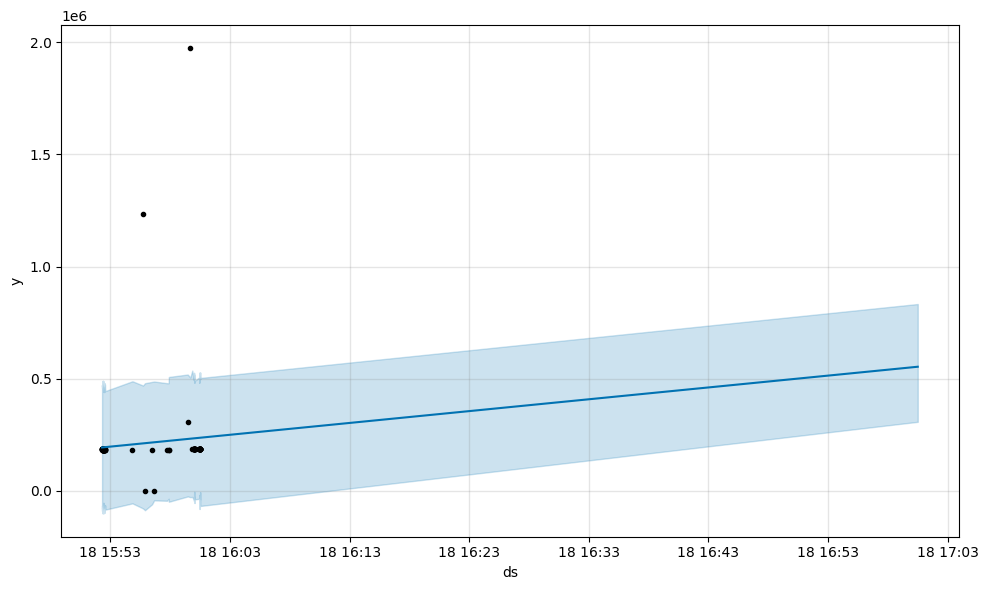

In [13]:
fig1 = m.plot(forecast)

/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


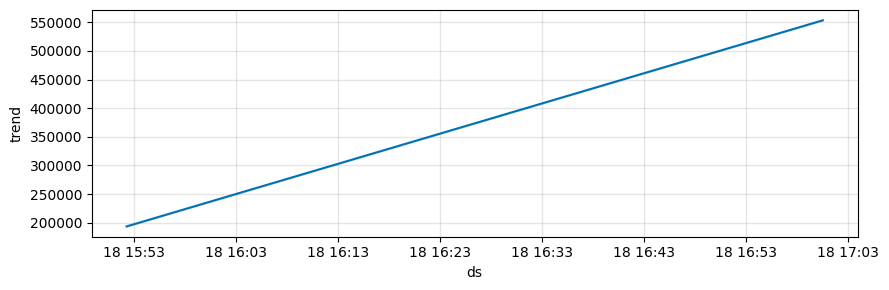

In [14]:
fig2 = m.plot_components(forecast)

In [18]:
forecast[["ds", "yhat"]].tail()

,ds,yhat
90,2024-08-18 16:00:30.268,236773.493009
91,2024-08-18 16:00:30.344,236780.176316
92,2024-08-18 16:00:30.387,236783.957661
93,2024-08-18 16:00:30.465,236790.816845
94,2024-08-18 17:00:30.465,553368.528485


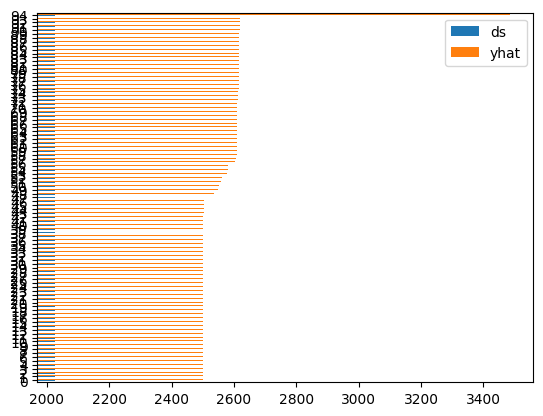

In [21]:
fig3 = forecast[["ds", "yhat"]].plot.barh()

In [22]:
forecast_dict = forecast[["ds", "yhat"]].to_dict()
pprint(forecast_dict)

{'ds': {0: Timestamp('2024-08-18 15:52:18.252000'),
        1: Timestamp('2024-08-18 15:52:18.352000'),
        2: Timestamp('2024-08-18 15:52:18.373000'),
        3: Timestamp('2024-08-18 15:52:18.491000'),
        4: Timestamp('2024-08-18 15:52:18.494000'),
        5: Timestamp('2024-08-18 15:52:20.092000'),
        6: Timestamp('2024-08-18 15:52:20.182000'),
        7: Timestamp('2024-08-18 15:52:20.945000'),
        8: Timestamp('2024-08-18 15:52:20.957000'),
        9: Timestamp('2024-08-18 15:52:21.043000'),
        10: Timestamp('2024-08-18 15:52:21.045000'),
        11: Timestamp('2024-08-18 15:52:21.047000'),
        12: Timestamp('2024-08-18 15:52:21.067000'),
        13: Timestamp('2024-08-18 15:52:21.263000'),
        14: Timestamp('2024-08-18 15:52:21.277000'),
        15: Timestamp('2024-08-18 15:52:22.755000'),
        16: Timestamp('2024-08-18 15:52:22.828000'),
        17: Timestamp('2024-08-18 15:52:23.724000'),
        18: Timestamp('2024-08-18 15:52:23.774000'),
   

In [29]:
new_data = {"x": [], "y": []}

ds = forecast_dict["ds"]
y = forecast_dict["yhat"]
for value in ds.values():
    new_data["x"].append(str(value))
for value in y.values():
    new_data["y"].append(value)

t_from = str(datetime.fromisoformat(new_data["x"][0]))
t_to = str(datetime.fromisoformat(new_data["x"][-1]))
new_data["t_from"] = t_from
new_data["t_to"] = t_to
new_data["created_at"] = datetime.now().isoformat()

pprint(new_data)

{'created_at': '2024-08-18T17:36:30.423618',
 't_from': '2024-08-18 15:52:18.252000',
 't_to': '2024-08-18 17:00:30.465000',
 'x': ['2024-08-18 15:52:18.252000',
       '2024-08-18 15:52:18.352000',
       '2024-08-18 15:52:18.373000',
       '2024-08-18 15:52:18.491000',
       '2024-08-18 15:52:18.494000',
       '2024-08-18 15:52:20.092000',
       '2024-08-18 15:52:20.182000',
       '2024-08-18 15:52:20.945000',
       '2024-08-18 15:52:20.957000',
       '2024-08-18 15:52:21.043000',
       '2024-08-18 15:52:21.045000',
       '2024-08-18 15:52:21.047000',
       '2024-08-18 15:52:21.067000',
       '2024-08-18 15:52:21.263000',
       '2024-08-18 15:52:21.277000',
       '2024-08-18 15:52:22.755000',
       '2024-08-18 15:52:22.828000',
       '2024-08-18 15:52:23.724000',
       '2024-08-18 15:52:23.774000',
       '2024-08-18 15:52:23.908000',
       '2024-08-18 15:52:23.938000',
       '2024-08-18 15:52:23.967000',
       '2024-08-18 15:52:24.010000',
       '2024-08-18 15:52

In [30]:
from dotenv import find_dotenv, dotenv_values
import pymongo

config = dotenv_values(find_dotenv())

try:
    atlas_uri = config.get("ATLAS_URI")
except:
    print("atlas uri not found")

db_name = "predict_test"
collection_name = "predictions"

mongo_client = pymongo.MongoClient(atlas_uri)

database = mongo_client[db_name]
collection = database[collection_name]

doc_count = collection.count_documents (filter = {})
print (f"Document count before delete : {doc_count:,}")

result = collection.delete_many(filter= {})
print (f"Deleted docs : {result.deleted_count}")

returned_id = collection.insert_one(new_data).inserted_id
print(returned_id)

Document count before delete : 1
Deleted docs : 1
66c23133f1e34672bd898c60
